In [218]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import set_config

# Constants
data_file_path = "./data/home-data-for-ml-course/train.csv"
test_size = 0.2
val_size = 0.2
random_state = 0
set_config(transform_output="pandas")

# Load data
df = pd.read_csv(data_file_path)

# Target and features
target = "SalePrice"
y = df.SalePrice

# All numeric without missing values
features = list(set(df.columns) - set(["SalePrice"]))
X = df[features]

In [219]:
# Drop columns with missing values
cols_with_missing_vals = X.isnull().sum()
cols_with_missing_vals = set(cols_with_missing_vals[cols_with_missing_vals > 0].index)
X = X.drop(cols_with_missing_vals, axis = 1)

In [224]:
pd.options.mode.chained_assignment = None

categorical_cols = list(X.select_dtypes(include=["object"]).columns)
discrete_features = (X.dtypes == "object").values
for col in categorical_cols:
    values, index = pd.factorize(X.loc[:, col])
    # Disable chained assignment for this line
    X[col] = values

pd.options.mode.chained_assignment = "warn"

In [239]:
from sklearn.feature_selection import mutual_info_regression

# Compute mutual information scores
mi_scores = pd.Series(
    data=mutual_info_regression(X, y, discrete_features=discrete_features),
    index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

OverallQual     0.563777
Neighborhood    0.497603
GrLivArea       0.482127
TotalBsmtSF     0.372196
GarageArea      0.365070
                  ...   
RoofMatl        0.000000
Id              0.000000
3SsnPorch       0.000000
MoSold          0.000000
MiscVal         0.000000
Length: 61, dtype: float64

<Axes: ylabel='None'>

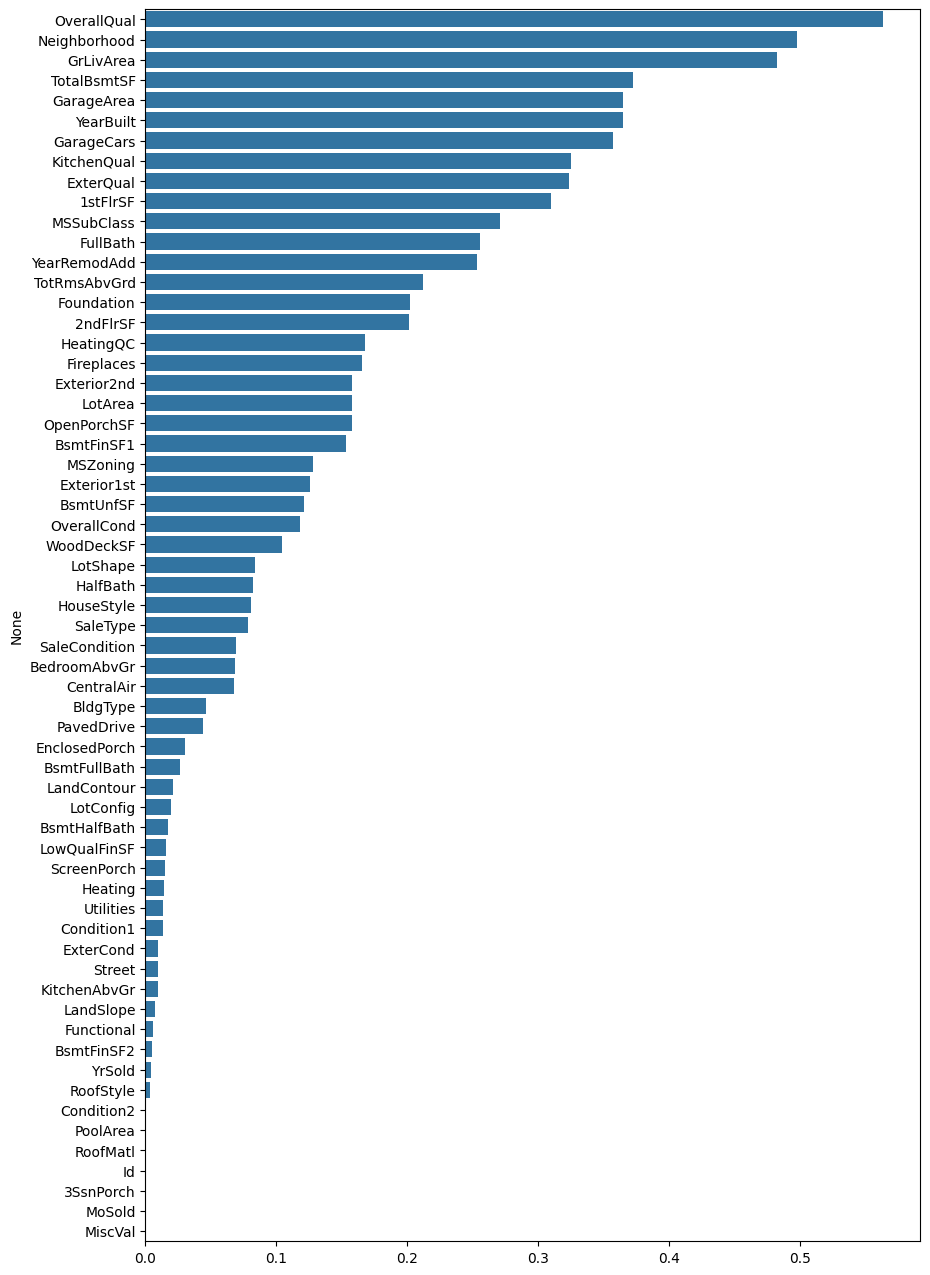

In [247]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10,16))
sns.barplot(x=mi_scores.values, y=mi_scores.index)